In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/RIVF2021/yolact/

/content/drive/MyDrive/RIVF2021/yolact


# <b/> <a/> IMPORT LIBRARIES </a> </b>

In [3]:
import os
import time
import cv2
import numpy as np
import glob
from PIL import Image
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data
import torch.distributed as dist


from modules.yolact import *
from config import *
from utils.datacoco import *
from utils.output_utils import *

# 1. <b/> <a/> SETUP </a> </b> 

In [4]:
cfg = set_config()
for key, value in cfg.__dict__.items():
  print ("{key} : {value}".format(key=key, value=value))

img_size : 550
classes : ('receipt',)
num_classes : 2
label_id : {1: 1}
coef_dim : 32
num_anchors : 3
lr : 1e-05
mode : train
device : cuda
cfg_name : resnet50
norm_mean : [103.94 116.78 123.68]
norm_std : [57.38 57.12 58.4 ]
scales : [32, 64, 128, 256, 512]
aspect_ratios : [1, 0.5, 2]
data_root : /content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/data/
train_bs : 8
img_path : /content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/data/mcocr2021_public_train_test_data/mcocr_public_train_test_shared_data/mcocr_train_data/train_images/
train_json : /content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/data/train.json
val_json : /content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/data/val.json
test_json : /content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/data/test.json
pos_iou_thre : 0.6
neg_iou_thre : 0.4
masks_to_train : 100
resume : True
weight_path : /content/drive/MyDrive/RIVF2021/yolact/weight/
batch_size : 8
test_image_path : /content/drive/MyDrive/RIVF2021/yolact/test_img.png
video : None
top_k : 200
n

In [5]:
train_dataset = Receipt_Detection(cfg, 'train')

len of image_train_path  :  924
len of seg_train_path    :  924
len of list_box_train    :  924


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

Device:  cuda


# 2. <b/> <a/> TRAIN </a> </b> 

In [7]:
import torch.backends.cudnn as cudnn
torch.autograd.set_detect_anomaly(True)

model = Yolact(cfg).to(device)

In [14]:
# Optimizer
# optimizer =optim.SGD(model.parameters(), lr=cfg.lr, momentum=0.9,weight_decay=5e-4)
optimizer =optim.SGD(model.parameters(), lr= cfg.lr, weight_decay=5e-4)

# Dataloader
train_data_loader = DataLoader(train_dataset, cfg.batch_size, shuffle=True, collate_fn=train_collate)

# Create folder to save weight
if not os.path.exists(cfg.weight_path):
  os.mkdir(cfg.weight_path)

In [15]:
# Continue training or not
cfg.resume = True

if cfg.resume:
  wtemp = glob.glob("/content/drive/MyDrive/RIVF2021/yolact/weight/latest*")
  model.load_weights(wtemp[0])
  start_step = int(wtemp[0].split('.pth')[0].split('_')[-1])+1
  print(f'\nResume training with \'{start_step}\'.\n')

else:
  model.init_weights()
  print(f'\nTraining from begining, weights initialized \n')
  start_step = 0 
  cfg.resume = True


Resume training with '69'.



In [ ]:
train_mode = True
time_last = time.time()
step = start_step


while train_mode:
  # Train 
  model.train()
  for i, (images,boxes,masks) in enumerate(train_data_loader):
    if torch.cuda.is_available():
      images = images.cuda().detach()
      boxes = [b.cuda().detach() for b in boxes]
      masks = [mask.cuda().detach() for mask in masks]

    loss_c, loss_b, loss_m, loss_s = model(images, boxes, masks)
    loss_total = loss_c + loss_b + loss_m + loss_s


    optimizer.zero_grad()
    loss_total.backward()
    optimizer.step()

    time_this = time.time()
    batch_time = time_this-time_last
    if i%30==0:
      print("Time for batch " , i , "/", len(train_data_loader) , "= " , batch_time , ", Loss  = " , loss_total.item() )
    time_last = time.time()

  save_latest(model, cfg_name = cfg.cfg_name , step = step)
  print("Epoch no ",step ,"  completed")
  print("----------------------------------------------------")
  step += 1

# 3. <b/> <a/> DETECT </a> </b>

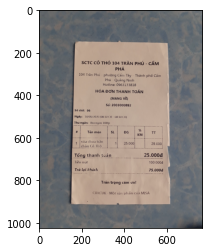

This is  receipt


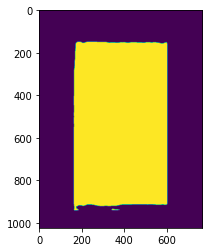

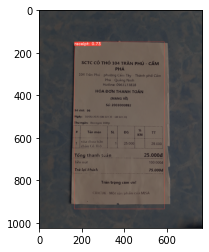

In [34]:
import random 
from google.colab.patches import cv2_imshow

cfg = set_config()
cfg.cutout = True 
cfg.visual_thre = 0.3
cfg.nms_iou_thre = 0.05
cfg.nms_score_thre = 0.6

cfg.mode='detect'

export_data_test_path = '/content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/data/val.json'

with open(export_data_test_path, "r") as F:
  data = json.load(F)
keys = list(data.keys())
index = random.randint(0, len(keys) - 1) 

cfg.test_image_path =  keys[index]

# Show original image
image = cv2.imread(cfg.test_image_path)
plt.imshow(image)
plt.show()

# Detect
net=Yolact(cfg).to(device)
path="/content/drive/MyDrive/RIVF2021/yolact/weight/latest_resnet50_74.pth"
net.load_weights(path)
net.eval()

with torch.no_grad():

  if cfg.test_image_path is not None:
    dataset= Receipt_Detection(cfg , mode='detect')
    data_loader = DataLoader(dataset,1,shuffle=False,pin_memory=True,collate_fn=detect_collate)
    for i, (img, img_origin, img_name) in enumerate(data_loader):
      
      if torch.cuda.is_available():
        img=img.cuda()
      img_h,img_w=img_origin.shape[0:2]
      class_p,box_p,coef_p,proto_p,anchors=net(img)

      ids_p, class_p, box_p, coef_p, proto_p = nms(class_p, box_p, coef_p, proto_p, anchors, cfg)
      ids_p, class_p, boxes_p, masks_p = after_nms(ids_p, class_p, box_p, coef_p,
                                                             proto_p, img_h, img_w, cfg, img_name=img_name)
      # Show masks
      j = 0
      for m in masks_p:
        print('This is ' , cfg.classes[ids_p[j]] )
        plt.imshow(m.cpu())
        plt.show()
        j+=1

      # Draw Box
      img_numpy = draw_img(ids_p, class_p, boxes_p, masks_p, img_origin, cfg, img_name=img_name)
      plt.imshow(img_numpy)
      plt.show()
      # cv2_imshow(img_numpy)